# 3. Topic Embedding

In this notebooks, we explore the topic embeddings and use it as a latent variable that connects tasks to constructs.

In [47]:
import pandas as pd
import numpy as np

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from bertopic import BERTopic
from top2vec import Top2Vec

import torch
from torch import nn
import torch.nn.functional as F

## Parameters

In [20]:
PUBMED_PATH = Path('data/pubmed_abstracts_preprocessed.csv.gz')

MODEL_NAME = 'pubmed10pct_top2vec'
VERSION = 'v202110111'

# MODEL_NAME = 'pubmed10pct_bertopic'
# VERSION = 'v202110121'

## Load the trained model

In [21]:
if 'top2vec' in MODEL_NAME:

  # pretrained model
  model: Top2Vec = Top2Vec.load(f'models/{MODEL_NAME}_{VERSION}.model')

  # documents
  PUBMED = pd.read_csv(PUBMED_PATH)
  PUBMED = PUBMED.query('pmid in @model.document_ids').copy()
  PUBMED['label'] = PUBMED['subcategory'].astype('category')

  # scores data frame
  scores = np.load(f'models/{MODEL_NAME}_{VERSION}.scores.npz')['arr_0']
  scores = PUBMED['pmid'].apply(lambda pmid: pd.Series(scores[model.doc_id2index[pmid]]))
  scores['pmid'] = PUBMED['pmid']
  scores['doc_id'] = scores['pmid'].apply(lambda pmid: model.doc_id2index[pmid])

elif 'bertopic' in MODEL_NAME:

  # BERTOPIC
  indices = np.load(f'models/{MODEL_NAME}_{VERSION}.idx.npz')['arr_0']
  model: BERTopic = BERTopic.load(f'models/{MODEL_NAME}_{VERSION}.model')
  topics = np.load(f'models/{MODEL_NAME}_{VERSION}.topics.npz')['arr_0']

  PUBMED = pd.read_csv(PUBMED_PATH)
  PUBMED = PUBMED[PUBMED.index.isin(indices)]
  PUBMED['label'] = PUBMED['subcategory'].astype('category')

  scores = np.load(f'models/{MODEL_NAME}_{VERSION}.probs.npz')['arr_0']
  scores = pd.DataFrame(scores)

In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# DEBUG simulated dataset
# n_topics = 300
# n_samples = 1000
# n_labels = 10
# X, y = make_classification(n_samples=n_samples, n_features=n_topics, n_classes=n_labels, n_informative=10, random_state=0)


# Tensorboard logger
logger = SummaryWriter()

# training parameter
n_epoches = 100
batch_size = 1000

# prepare the X and y and parameters
X = scores.drop(columns=['pmid','doc_id'], errors='ignore').values
y = PUBMED['label'].cat.codes.values
n_topics = X.shape[1]
n_samples = X.shape[0]
n_labels = y.max() + 1
train_size = int(n_samples * .9)
test_size = n_samples - train_size

# prepare the test/train datasets
X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.long)
dataset = TensorDataset(X, y)
train_subset, test_subset = random_split(dataset, lengths=(train_size, test_size))
X_test, y_test = dataset[test_subset.indices]

model = nn.Sequential(
  nn.Embedding(n_labels, n_topics)
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

logger.add_graph(model, y)

trace = []

for epoch in tqdm(range(n_epoches)):

  model.train()
  for X_batch, y_batch in DataLoader(train_subset, batch_size=batch_size, shuffle=True):
    model.zero_grad()
    X_pred = model(y_batch)
    loss = criterion(X_batch, X_pred)
    logger.add_scalar('loss/train', loss.detach(), epoch)
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad():
    X_pred = model(y_test)
    loss = criterion(X_test, X_pred)
    logger.add_scalar('loss/test', loss.detach(), epoch)


H = pd.DataFrame(next(model.parameters()).detach().numpy())


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


# Maximum Likelihood Estimator

Assuming all the observed scores of each label are drawn from a normal distribution, we will use MLE to estimate the topic embeddings of the labels from observed values of the documents.

In [48]:
# MLE

scores['label'] = PUBMED['label']
H = scores.drop(columns=['pmid','doc_id'], errors='ignore').groupby('label').apply(
  lambda data: data.mean()
).reset_index(0)


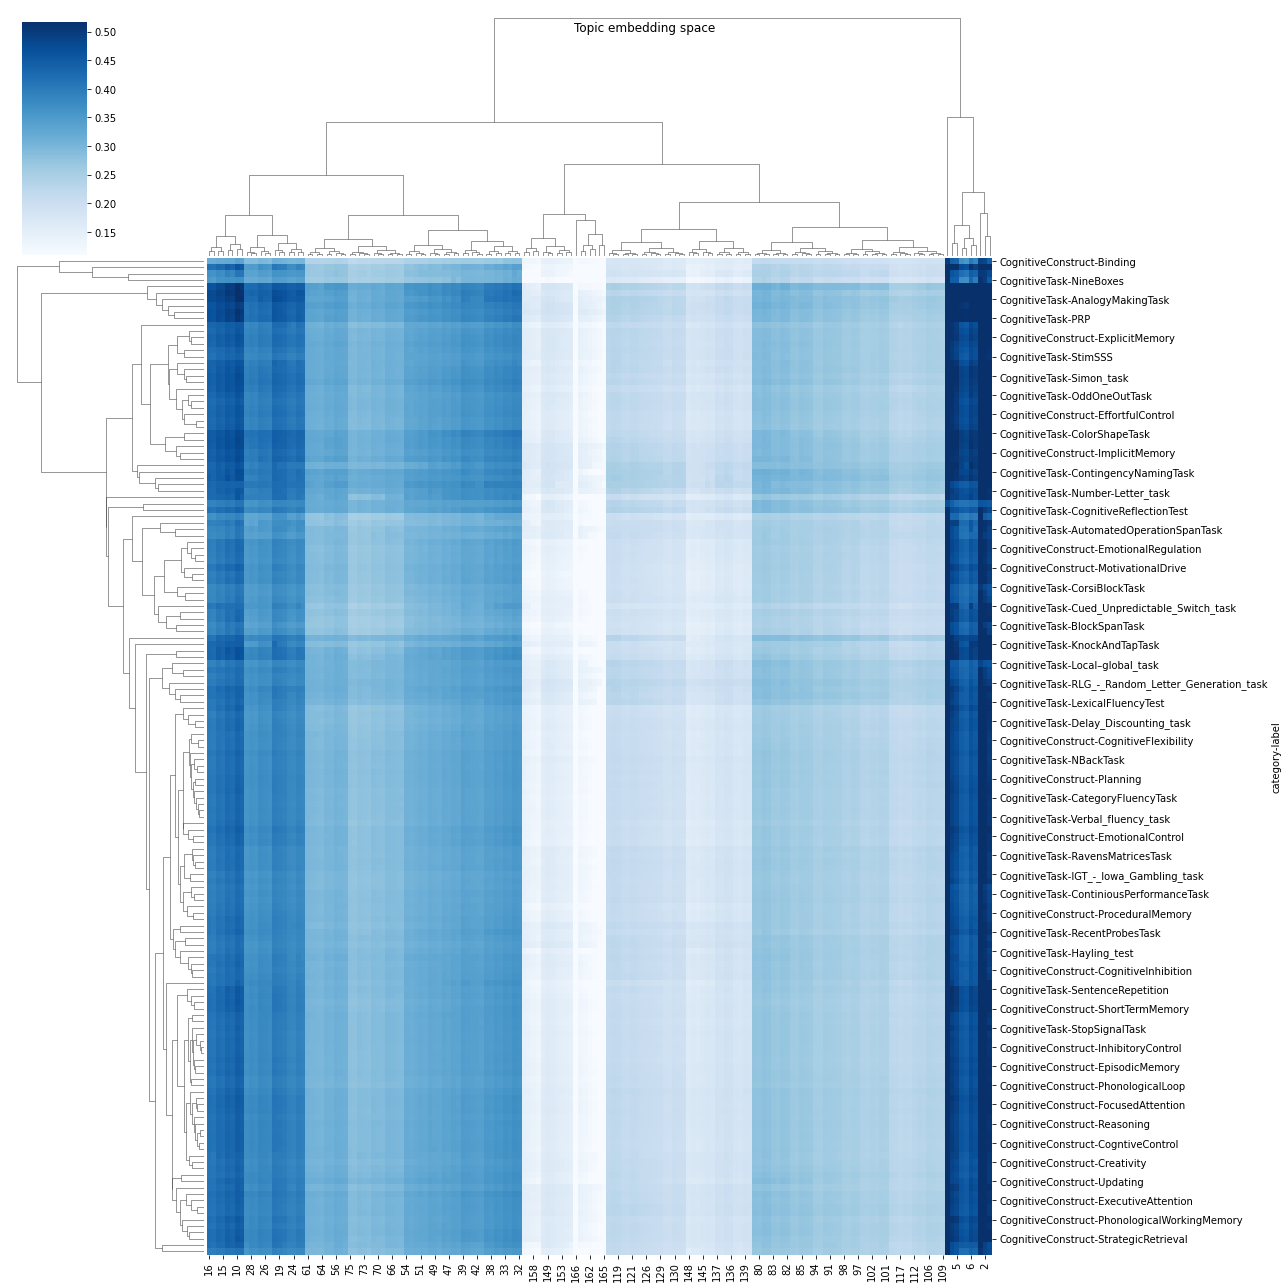

0         1    \
category           label                                                 
CognitiveTask      AnalogyMakingTask                0.644100  0.634825   
                   AntiSaccadeTask                  0.623135  0.571920   
CognitiveConstruct Attention                        0.634819  0.566711   
CognitiveTask      AttentionNetworkTest             0.645361  0.548562   
CognitiveConstruct AttentionalControl               0.638314  0.570248   
...                                                      ...       ...   
                   VisuospatialSketchpad            0.598858  0.557392   
                   VisuospatialWorkingMemory        0.635459  0.559265   
                   Volition                         0.616585  0.548068   
CognitiveTask      WCST_-_Wisconsin_Card_Sort_Test  0.608166  0.537688   
CognitiveConstruct WorkingMemory                    0.637625  0.565644   

                                                         2         3    \
category           label                                                 
CognitiveTask      AnalogyMakingTask                0.585796  0.582364   
                   AntiSaccadeTask                  0.548575  0.519223   
CognitiveConstruct Attention                        0.535749  0.515423   
CognitiveTask      AttentionNetworkTest             0.512741  0.490741   
CognitiveConstruct AttentionalControl               0.542420  0.523711   
...                                                      ...       ...   
                   VisuospatialSketchpad            0.524502  0.509496   
                   VisuospatialWorkingMemory        0.537728  0.521279   
                   Volition                         0.515594  0.499710   
CognitiveTask      WCST_-_Wisconsin_Card_Sort_Test  0.507898  0.488029   
CognitiveConstruct WorkingMemory                    0.534700  0.515076   

                                                         4         5    \
category           label                                                 
CognitiveTask      AnalogyMakingTask                0.561635  0.532993   
                   AntiSaccadeTask                  0.502985  0.492536   
CognitiveConstruct Attention                        0.500089  0.487711   
CognitiveTask      AttentionNetworkTest             0.475190  0.465120   
CognitiveConstruct AttentionalControl               0.509755  0.497651   
...                                                      ...       ...   
                   VisuospatialSketchpad            0.492807  0.477538   
                   VisuospatialWorkingMemory        0.503180  0.489859   
                   Volition                         0.488278  0.477325   
CognitiveTask      WCST_-_Wisconsin_Card_Sort_Test  0.472840  0.461662   
CognitiveConstruct WorkingMemory                    0.499983  0.487506   

                                                         6         7    \
category           label                                                 
CognitiveTask      AnalogyMakingTask                0.529980  0.529393   
                   AntiSaccadeTask                  0.479534  0.469007   
CognitiveConstruct Attention                        0.477349  0.468334   
CognitiveTask      AttentionNetworkTest             0.454508  0.446675   
CognitiveConstruct AttentionalControl               0.487784  0.479309   
...                                                      ...       ...   
                   VisuospatialSketchpad            0.462668  0.448464   
                   VisuospatialWorkingMemory        0.479483  0.469772   
                   Volition                         0.468257  0.459572   
CognitiveTask      WCST_-_Wisconsin_Card_Sort_Test  0.451496  0.442275   
CognitiveConstruct WorkingMemory                    0.477203  0.468386   

                                                         8         9    ...  \
category           label                                                ...   
CognitiveTask      AnalogyMakingTask           

In [49]:

# convert to a dataframe, indexed by label and category
labels = PUBMED['label'].cat.categories[H.index]
categories = labels.to_series().apply(lambda lbl: PUBMED.query('label == @lbl')['category'].unique().item())
indices = categories.to_frame().reset_index().rename(columns={0: 'category', 'index': 'label'})
H.index = pd.MultiIndex.from_frame(indices).reorder_levels(['category', 'label'])
H.drop(columns=['label'], errors='ignore', inplace=True)
# DEBUG H = H.query('not index.get_level_values("label").str.contains("ColumbiaCardTask")')

sns.clustermap(H, figsize=(18, 18), cmap='Blues', robust=True)
plt.suptitle('Topic embedding space')
plt.show()
H


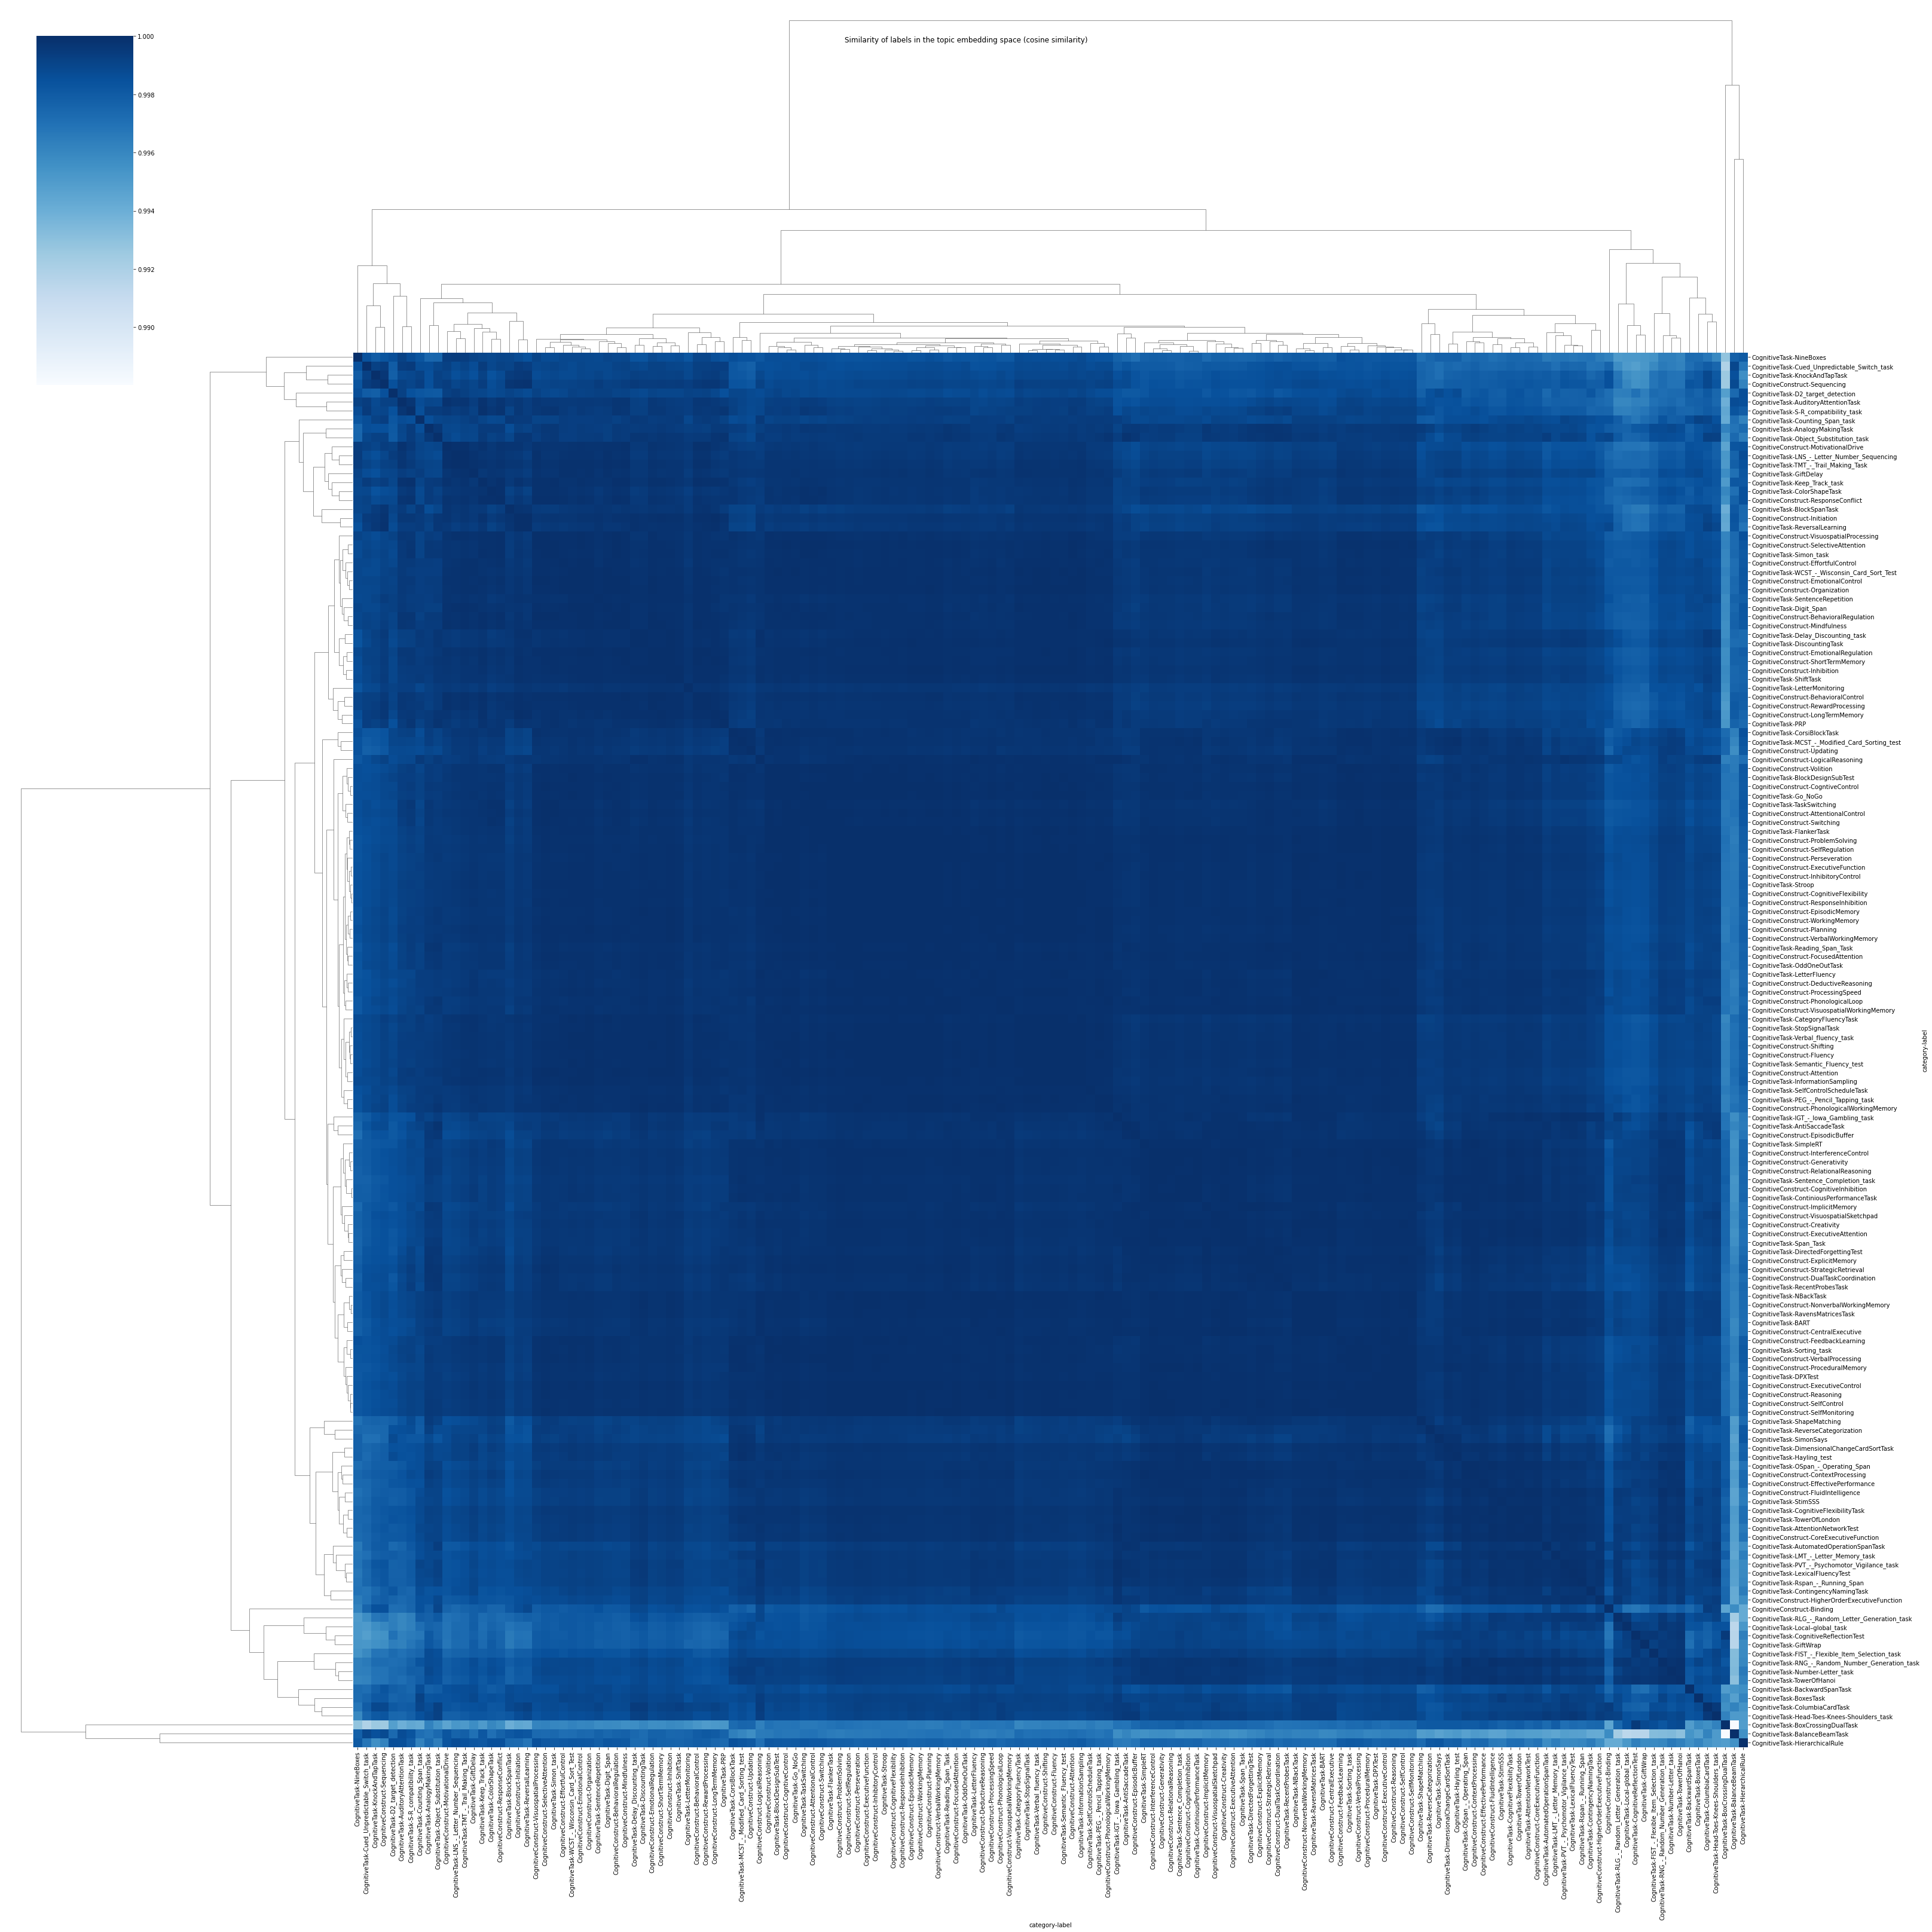

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
H_sim = pd.DataFrame(cosine_similarity(H), columns=H.index, index=H.index)
sns.clustermap(H_sim, cmap='Blues', figsize=(45,45))
plt.suptitle('Similarity of labels in the topic embedding space (cosine similarity)')
plt.show()

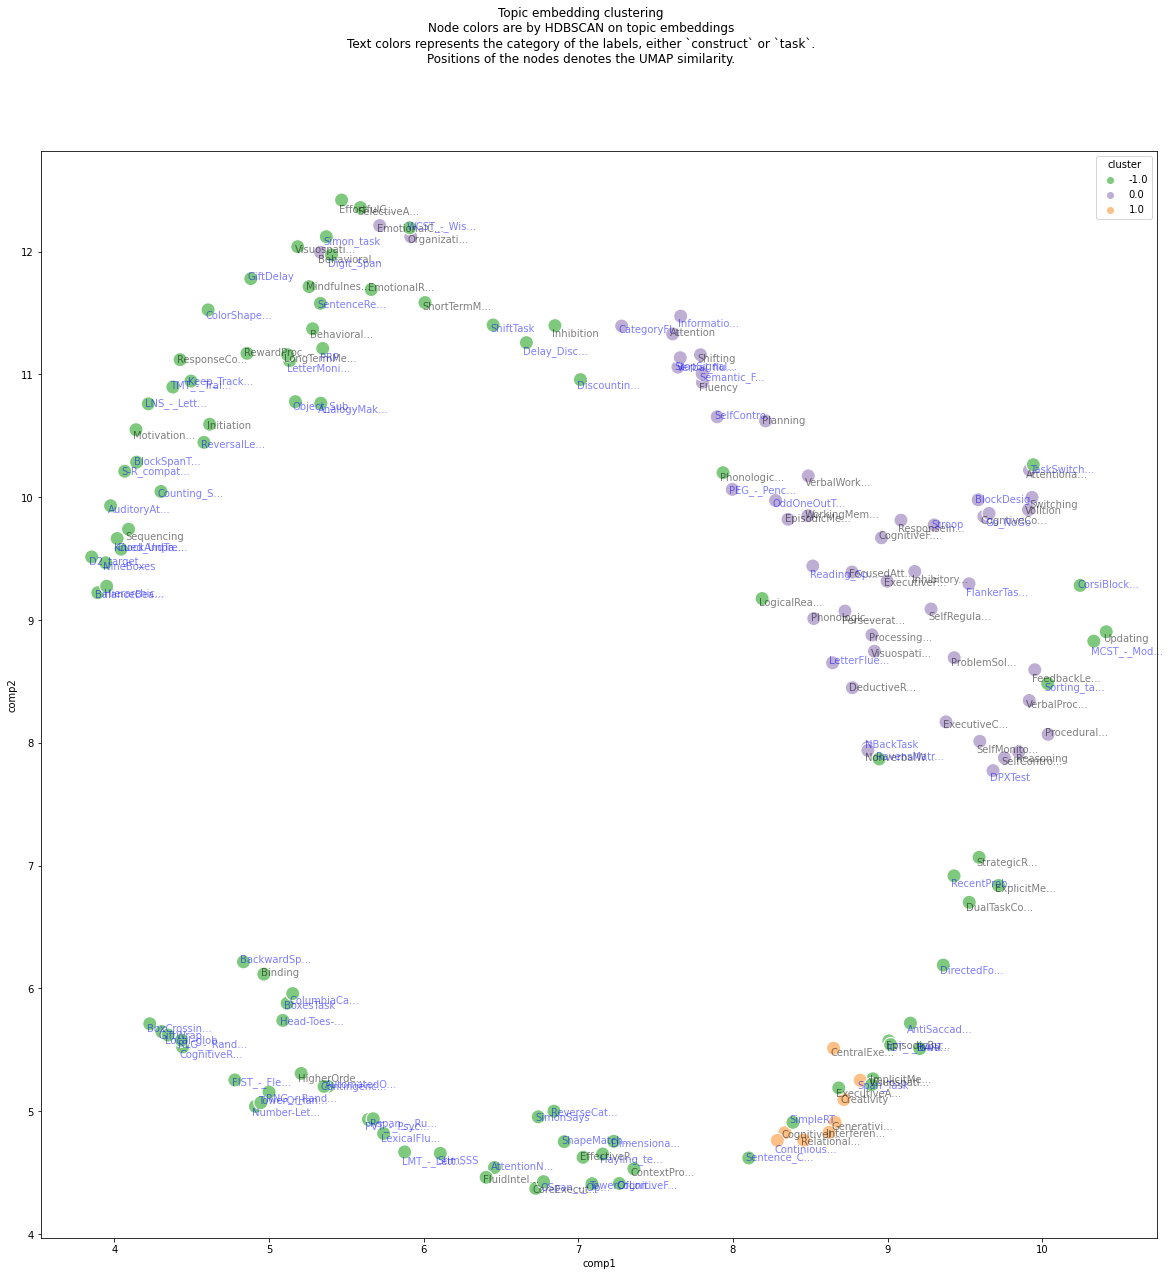

In [55]:
import hdbscan
import umap
from sklearn.decomposition import PCA


H_projection = umap.UMAP(n_components=2, random_state=0).fit_transform(H_sim)
# H_projection = PCA(n_components=2, random_state=0).fit_transform(H)

clusters = hdbscan.HDBSCAN().fit_predict(H_sim).reshape(-1,1)

cat_colors_palette = ['black','blue']
cat_colors = H.index.to_frame()['category'].astype('category').cat.codes.to_list()
cat_colors = [cat_colors_palette[c] for c in cat_colors]

H_projection = np.hstack((H_projection, clusters))

fig, ax = plt.subplots(1,1, figsize=(20,20))

sns.scatterplot(
    data=pd.DataFrame(H_projection, columns=['comp1', 'comp2', 'cluster']),
    x='comp1', y='comp2', hue='cluster', ax=ax, palette='Accent', s=200)

for (cat, lbl), (x, y, c), color in zip(H.index.to_list(), H_projection, cat_colors):
    lbl = f'{lbl[:10]}...' if len(lbl)>10 else lbl
    ax.text(x-0.02, y-np.random.random()*.1, f'{lbl}', alpha=0.5, fontsize=10, color=color)

plt.suptitle(
    'Topic embedding clustering\n'
    'Node colors are by HDBSCAN on topic embeddings\n'
    'Text colors represents the category of the labels, either `construct` or `task`.\n'
    'Positions of the nodes denotes the UMAP similarity.')
plt.show()
